# บทที่ 6n - การเทรนโมเดลบน Hugging Face พาร์ท 2.1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ai-builders/curriculum/blob/main/notebooks/06n_Machine_Translation.ipynb)


In [ ]:
!pip install datasets==1.17.0 transformers[sentencepiece]==4.15.0
!pip install accelerate==0.5.1
# To run the training on TPU, you will need to uncomment the followin line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs
!pip install sacrebleu==2.0.0

     |████████████████████████████████| 306 kB 22.8 MB/s 
     |████████████████████████████████| 3.4 MB 61.8 MB/s 
     |████████████████████████████████| 133 kB 77.4 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 243 kB 76.1 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 144 kB 75.0 MB/s 
     |████████████████████████████████| 271 kB 76.1 MB/s 
     |████████████████████████████████| 160 kB 73.7 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 3.3 MB 57.8 MB/s 
     |████████████████████████████████| 895 kB 72.6 MB/s 
     |████████████████████████████████| 1.2 MB 27.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 58 kB 6.8 MB/s 
Reading package lists... Done
Building depe

In [ ]:
!git config --global user.email "hugging_face_email"
!git config --global user.name "hugging_face_user_name"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


# โจทย์วันนี้: สร้างเครื่องแปลภาษาจาก EN-FR 

In [ ]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr") # ดาต้าเซ็ต en-fr

Downloading:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Using custom data configuration en-fr-lang1=en,lang2=fr


Downloading:   0%|          | 0.00/7.05M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset kde4 downloaded and prepared to /root/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [ ]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

In [ ]:
split_datasets["validation"] = split_datasets.pop("test")

In [ ]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr" # โมเดลสำเร็จรูป
translator = pipeline("translation", model=model_checkpoint)

Downloading:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

In [ ]:
translator("Default to expanded threads") # ผลการแปล

[{'translation_text': 'Par défaut pour les threads élargis'}]

In [ ]:
split_datasets["train"][1]["translation"] # ผลเฉลย

{'en': 'Default to expanded threads',
 'fr': 'Par défaut, développer les fils de discussion'}

# การจัดการดาต้า (Processing)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="tf")

In [ ]:
en_sentence = split_datasets["train"][1]["translation"]["en"]
fr_sentence = split_datasets["train"][1]["translation"]["fr"]

inputs = tokenizer(en_sentence)
with tokenizer.as_target_tokenizer():
    targets = tokenizer(fr_sentence)

# สิ่งที่ต้องระวัง
ในบางครั้งตัวตัดคำ (tokenizer) ไม่ได้รองรับภาษานั้นๆ จะต้องเลือกใช้ให้ถูกต้องด้วย ซึ่งถ้าไม่ได้ใช้ 
```
with tokenizer.as_target_tokenizer():
```
จะทำให้การตัดคำของเราผิดได้ ยกตัวอย่างเช่น:



In [ ]:
wrong_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['▁Par', '▁dé', 'f', 'aut', ',', '▁dé', 've', 'lop', 'per', '▁les', '▁fil', 's', '▁de', '▁discussion', '</s>']
['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']


In [ ]:
max_input_length = 128
max_target_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

  0%|          | 0/190 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

# การ Finetuning โมเดลโดยใช้ฟังก์ชั่นสำเร็จรูป

# สิ่งที่เปลี่ยนไปจากโจทย์ก่อนหน้า?
= จากงานเดิมที่เราต้องใช้ AutoModelForSequenceClassification สำหรับการทำนายประโยค เราจะต้องใช้ Seq2Seq ในการแปลภาษาแทน

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# อะไรคือ Seq2Seq?
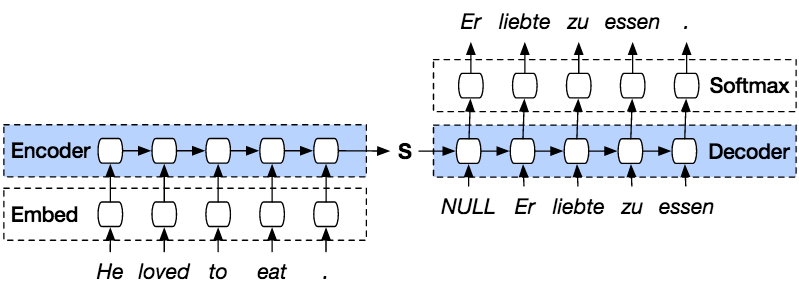

from: https://www.guru99.com/seq2seq-model.html

# ฟังก์ชั่นพิเศษ DataCollatorForSeq2Seq

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['attention_mask', 'input_ids', 'labels', 'decoder_input_ids'])

อย่าลืม Padding!! 
-100 = padding

In [ ]:
batch["labels"]

tensor([[  577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
           550,  7032,  5821,  7907, 12649,     0]])

# Input ของ Decoder
= เอา input ของ encoder มา right-shift หรือขยับไปด้านขวา 1 ช่อง เช่น 


```
Encoder = "ฉัน กิน ข้าว"
Decoder = "<start> ฉัน กิน ข้าว <end>"
```




In [ ]:
batch["decoder_input_ids"]

tensor([[59513,   577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,
         59513, 59513, 59513, 59513, 59513, 59513],
        [59513,  1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,
           817,   550,  7032,  5821,  7907, 12649]])

# วิธีประเมินผลของโมเดล?
= ในงานการแปลภาษา เราจะใช้ "Blue score" เป็นสกอร์ที่บอกว่าการแปลของเราใกล้เคียงกับเฉลยแค่ไหน โดยการเทียบ "ชุดของคำ โดยนำมาจาก เฉลย & จากการทำนาย" 

อ่านเพิ่มเติม: https://en.wikipedia.org/wiki/BLEU

In [ ]:
from datasets import load_metric

metric = load_metric("sacrebleu")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

# ตย.1

In [ ]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'bp': 0.9200444146293233,
 'counts': [11, 6, 4, 3],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'ref_len': 13,
 'score': 46.750469682990165,
 'sys_len': 12,
 'totals': [12, 11, 10, 9]}

# ตย.2

In [ ]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'bp': 0.10539922456186433,
 'counts': [1, 0, 0, 0],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'ref_len': 13,
 'score': 1.683602693167689,
 'sys_len': 4,
 'totals': [4, 3, 2, 1]}

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-fr",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True, # ถ้าใช้ GPU
    push_to_hub=True,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr into local empty directory.
Using amp half precision backend


In [ ]:
trainer.evaluate(max_length=max_target_length) # ก่อนเทรน สกอร์ก็ดีพอตัว

***** Running Evaluation *****
  Num examples = 21018
  Batch size = 64


{'eval_bleu': 39.27124165416069,
 'eval_loss': 1.6964441537857056,
 'eval_runtime': 1347.2741,
 'eval_samples_per_second': 15.6,
 'eval_steps_per_second': 0.244}

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 189155
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5912


Step,Training Loss
500,1.416600
1000,1.224000
1500,1.174500
2000,1.136800
2500,1.130400
3000,1.082400
3500,1.084300
4000,1.049700
4500,1.049200
5000,1.055300


Saving model checkpoint to marian-finetuned-kde4-en-to-fr/checkpoint-5912
Configuration saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/config.json
Model weights saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/pytorch_model.bin
tokenizer config file saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/tokenizer_config.json
Special tokens file saved in marian-finetuned-kde4-en-to-fr/checkpoint-5912/special_tokens_map.json
tokenizer config file saved in marian-finetuned-kde4-en-to-fr/tokenizer_config.json
Special tokens file saved in marian-finetuned-kde4-en-to-fr/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=5912, training_loss=1.123947184850463, metrics={'train_runtime': 1246.3041, 'train_samples_per_second': 151.773, 'train_steps_per_second': 4.744, 'total_flos': 3773950253531136.0, 'train_loss': 1.123947184850463, 'epoch': 1.0})

In [ ]:
trainer.evaluate(max_length=max_target_length) #จาก 39 => 50 !!

***** Running Evaluation *****
  Num examples = 21018
  Batch size = 64


{'epoch': 1.0,
 'eval_bleu': 50.20410659441166,
 'eval_loss': 0.9643106460571289,
 'eval_runtime': 1523.0974,
 'eval_samples_per_second': 13.8,
 'eval_steps_per_second': 0.216}

In [ ]:
trainer.push_to_hub(tags="translation", commit_message="Training complete") # อัพขึ้น hugging face

Saving model checkpoint to marian-finetuned-kde4-en-to-fr
Configuration saved in marian-finetuned-kde4-en-to-fr/config.json
Model weights saved in marian-finetuned-kde4-en-to-fr/pytorch_model.bin
tokenizer config file saved in marian-finetuned-kde4-en-to-fr/tokenizer_config.json
Special tokens file saved in marian-finetuned-kde4-en-to-fr/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.
To https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr
   6722933..a9aec84  main -> main

To https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr
   a9aec84..ba8bf15  main -> main



'https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/commit/a9aec8499fa2dc158869957189822bb6daed6b2d'

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "mrp/marian-finetuned-kde4-en-to-fr" # ลองโหลดโมเดลมาใช้
translator = pipeline("translation", model=model_checkpoint)

https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp75iu2h1l


Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/1c92fe3bf0b9fc397b3b68fed2eb636f7f5c3f006a9f0b044e449b477b9d4f7c.f39bd3c2362a84b75eb6d388a96515ed46798865b8f6377283b55bbb1996776d
creating metadata file for /root/.cache/huggingface/transformers/1c92fe3bf0b9fc397b3b68fed2eb636f7f5c3f006a9f0b044e449b477b9d4f7c.f39bd3c2362a84b75eb6d388a96515ed46798865b8f6377283b55bbb1996776d
loading configuration file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1c92fe3bf0b9fc397b3b68fed2eb636f7f5c3f006a9f0b044e449b477b9d4f7c.f39bd3c2362a84b75eb6d388a96515ed46798865b8f6377283b55bbb1996776d
Model config MarianConfig {
  "_name_or_path": "mrp/marian-finetuned-kde4-en-to-fr",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectu

Downloading:   0%|          | 0.00/285M [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/858f96e2318a8ab29a81191ea997225a0d8ceaa75ba7c294f39d632a1bc35d9c.b529404a954b1d8a67c658370448d9b176e190317e223f476e8141087bfa2d65
creating metadata file for /root/.cache/huggingface/transformers/858f96e2318a8ab29a81191ea997225a0d8ceaa75ba7c294f39d632a1bc35d9c.b529404a954b1d8a67c658370448d9b176e190317e223f476e8141087bfa2d65
loading weights file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/858f96e2318a8ab29a81191ea997225a0d8ceaa75ba7c294f39d632a1bc35d9c.b529404a954b1d8a67c658370448d9b176e190317e223f476e8141087bfa2d65
All model checkpoint weights were used when initializing MarianMTModel.

All the weights of MarianMTModel were initialized from the model checkpoint at mrp/marian-finetuned-kde4-en-to-fr.
If your task is similar to the task the model of

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/ed3231b95a780739cc842aa29a93409c9dfbf2e3ba80885576a4e282c576d06b.3e2cb67f13186337b50025aa21e23e3239082196cba3fc46ed38bc79db27e477
creating metadata file for /root/.cache/huggingface/transformers/ed3231b95a780739cc842aa29a93409c9dfbf2e3ba80885576a4e282c576d06b.3e2cb67f13186337b50025aa21e23e3239082196cba3fc46ed38bc79db27e477
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/source.spm not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_25s3v0v


Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/source.spm in cache at /root/.cache/huggingface/transformers/c0a2d13852064e272a23fc09e1deb72e2a5cbc31b3ce66e428a655710cac0999.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
creating metadata file for /root/.cache/huggingface/transformers/c0a2d13852064e272a23fc09e1deb72e2a5cbc31b3ce66e428a655710cac0999.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/target.spm not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpi8k0mhbw


Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/target.spm in cache at /root/.cache/huggingface/transformers/ace0835aa07e3b9ac9ae16fe078f6bdd34010d2ba31c7fe4e1a3725bd812b145.7a3fadd05a0cee82a22786164d20d49e7b313753bf53c7e219cd382f47c08871
creating metadata file for /root/.cache/huggingface/transformers/ace0835aa07e3b9ac9ae16fe078f6bdd34010d2ba31c7fe4e1a3725bd812b145.7a3fadd05a0cee82a22786164d20d49e7b313753bf53c7e219cd382f47c08871
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwo259mxq


Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/350b53a616e636856a2aca335d69b5a6f8669c6b68987619c97fb3b53a4eb997.f0e9eb9c8120de9b276d39c458593bb6f470220163cc5be81c17eabfd243816d
creating metadata file for /root/.cache/huggingface/transformers/350b53a616e636856a2aca335d69b5a6f8669c6b68987619c97fb3b53a4eb997.f0e9eb9c8120de9b276d39c458593bb6f470220163cc5be81c17eabfd243816d
https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcd5dj2o8


Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

storing https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/706ccba74244d26113decf63eed9126d5c77b14d348c94424157894a5162fa99.294ebaa4cd17bb284635004c92d2c4d522ec488c828dcce0c2471b6f28e3fe82
creating metadata file for /root/.cache/huggingface/transformers/706ccba74244d26113decf63eed9126d5c77b14d348c94424157894a5162fa99.294ebaa4cd17bb284635004c92d2c4d522ec488c828dcce0c2471b6f28e3fe82
loading file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/source.spm from cache at /root/.cache/huggingface/transformers/c0a2d13852064e272a23fc09e1deb72e2a5cbc31b3ce66e428a655710cac0999.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
loading file https://huggingface.co/mrp/marian-finetuned-kde4-en-to-fr/resolve/main/target.spm from cache at /root/.cache/huggingface/transformers/ace0835aa07e3b9ac9ae16fe078f6bdd34010d2ba31c7fe4e1a3725bd812b145.7a3fadd05a0cee82a22786164d20d49e7

[{'translation_text': 'Par défaut pour les fils de discussion étendus'}]

In [ ]:
translator("Default to expanded threads")

[{'translation_text': 'Par défaut pour les fils de discussion étendus'}]